In [1]:
import pandas as pd
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from datetime import datetime
import kagglehub
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from langdetect import detect, DetectorFactory
from wordcloud import WordCloud

/Users/yaren/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/yaren/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = kagglehub.dataset_download("rusiano/madrid-airbnb-data")
print("Path to dataset files:", path)

dataset_files = os.listdir(path)
print("Files in dataset:", dataset_files)

print([file for file in dataset_files if file.endswith('.csv')])

files_csv = [file for file in dataset_files if file.endswith('.csv')]

for csv_file in files_csv:
    if csv_file == 'calendar.csv':
        calendar = pd.read_csv(os.path.join(path, csv_file))
    elif csv_file == 'reviews.csv':
        reviews = pd.read_csv(os.path.join(path, csv_file))
    elif csv_file == 'reviews_detailed.csv':
        reviews_detailed = pd.read_csv(os.path.join(path, csv_file))
    elif csv_file == 'neighbourhoods.csv':
        neighbourhoods = pd.read_csv(os.path.join(path, csv_file))
    elif csv_file == 'listings.csv':
        listings = pd.read_csv(os.path.join(path, csv_file))
    elif csv_file == 'listings_detailed.csv':
        listings_detailed = pd.read_csv(os.path.join(path, csv_file))
    else:
        print("Error: too many files in dataset")

Path to dataset files: /Users/yaren/.cache/kagglehub/datasets/rusiano/madrid-airbnb-data/versions/2
Files in dataset: ['reviews.csv', 'neighbourhoods.geojson', 'reviews_detailed.csv', 'neighbourhoods.csv', 'listings.csv', 'calendar.csv', 'listings_detailed.csv']
['reviews.csv', 'reviews_detailed.csv', 'neighbourhoods.csv', 'listings.csv', 'calendar.csv', 'listings_detailed.csv']


In [3]:
#listings.columns

In [4]:
listings_detailed['host_acceptance_rate'] = listings_detailed['host_acceptance_rate'].str.rstrip('%').astype(float) / 100
#listings_detailed.columns

 # Target Value Distribution Analysis Before Preprocessing

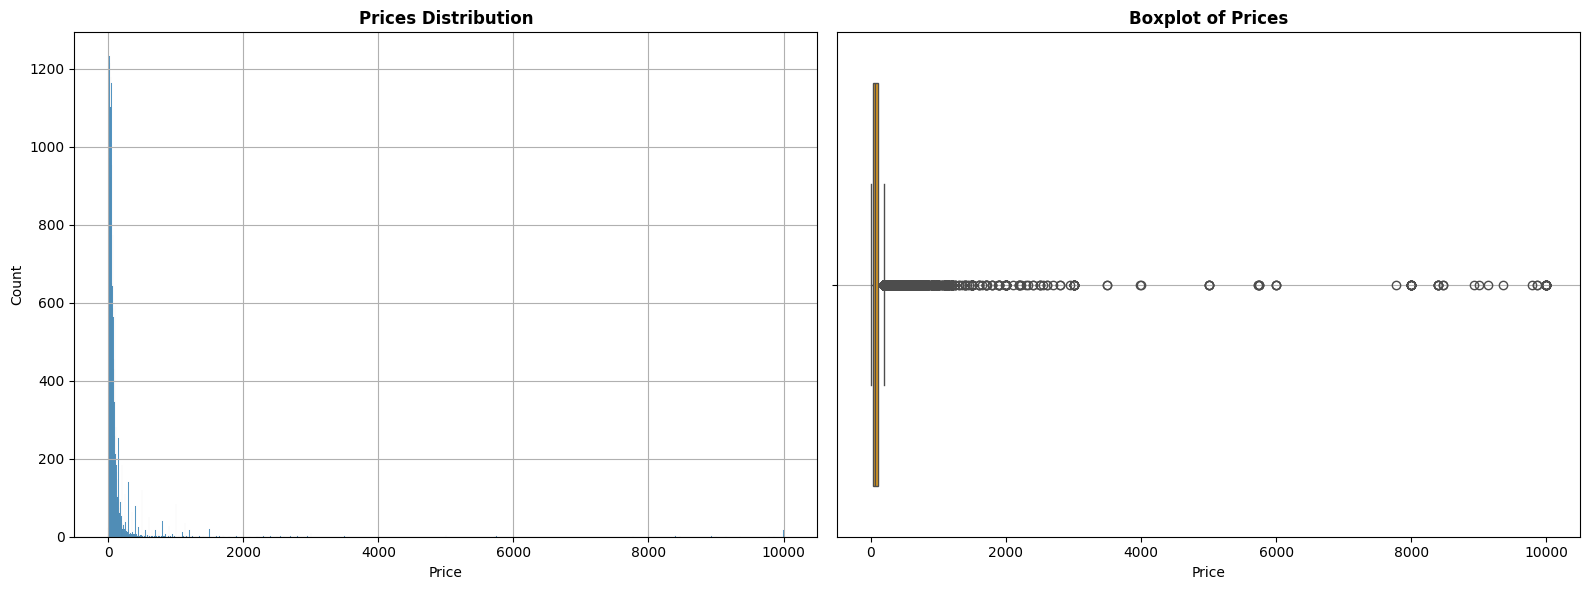

In [5]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.histplot(listings['price'])
plt.title('Prices Distribution', weight='bold')
plt.xlabel('Price')
plt.grid()

plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.boxplot(x=listings['price'], color='orange')
plt.title('Boxplot of Prices', weight='bold')
plt.xlabel('Price')
plt.grid(axis='y')  # Add gridlines for the boxplot

plt.tight_layout()
plt.show()

# Preprocessing

Combine some potentially important features from the detailed listings into the dataset.

In [6]:
columns_to_add = ['bedrooms', 'accommodates', 'id', 'beds', 'host_acceptance_rate', 'bathrooms_text', 'review_scores_rating', 'description']
merged_df = pd.merge(listings, listings_detailed[columns_to_add], on='id', how='outer')

# create a column only for text 
merged_df['text'] = merged_df['name'].fillna('') + " " + merged_df['description'].fillna('') # will be used later
merged_df = merged_df.drop(['description'], axis = 1)

Last review is just a date and is not suitable as a feature. Calculate the number of days elapsed since that date and use it as a feature.

In [7]:
merged_df['last_review'] = pd.to_datetime(listings['last_review'], errors='coerce')
merged_df['last_review'].min(skipna=True) # Timestamp('2012-01-01 00:00:00')
merged_df["last_review"] = merged_df["last_review"].fillna("2012-01-01")
merged_df["last_review"] = pd.to_datetime(listings["last_review"])
merged_df["days_since_last_review"] = (datetime.now() - merged_df["last_review"]).dt.days

The language used in the title can also potentially influence the price.

In [8]:
DetectorFactory.seed = 0
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'  

merged_df['language'] = merged_df['name'].apply(detect_language)
merged_df['language'] = merged_df['language'].apply(lambda x: x if x in ['en', 'es'] else 'en') #otherwise en because its a foreign language too and the distribution shows that spanish and english are the two most common ones
#merged_df.head()

The number and type of bathrooms in the accommodation are also likely important. Extract this information from the 'bathrooms text' column. (Ps: The 'bathrooms' column had too many missing values, so I used 'bathrooms text' instead.)

In [9]:
merged_df['bathrooms_number'] = merged_df['bathrooms_text'].str.extract(r'(\d+\.?\d*)').astype(float)
merged_df['bathrooms_type'] = merged_df['bathrooms_text'].apply(
    lambda x: 'shared' if isinstance(x, str) and 'shared' in x.lower() else (
        'private' if isinstance(x, str) and 'private' in x.lower() else 'unknown'
    )
)
merged_df.loc[merged_df['room_type'].isin(['Entire home/apt', 'Hotel room', 'Private room']) & (merged_df['bathrooms_type'] == 'unknown'), 'bathrooms_type'] = 'private'
merged_df["bathrooms_number"] = merged_df["bathrooms_number"].fillna(1)

Handling missing values, dropping unnecessary columns and removing outliers detected using IQR method.

In [10]:
merged_df["reviews_per_month"] = merged_df["reviews_per_month"].fillna(0)
merged_df["bedrooms"] = merged_df["bedrooms"].fillna(1)
merged_df["beds"] = merged_df["beds"].fillna(1)
merged_df["host_acceptance_rate"] = merged_df["host_acceptance_rate"].fillna(0)
merged_df["review_scores_rating"] = merged_df["review_scores_rating"].fillna(0)

data = merged_df.drop(["id", 'last_review', 'host_name', 'bathrooms_text'], axis=1)

cols = ["price", "minimum_nights", "calculated_host_listings_count", "reviews_per_month", "number_of_reviews"]

for col in cols:
    lower_bound, upper_bound = data[col].quantile([0.05, 0.95])
    data = data[(data[col] > lower_bound) & (data[col] < upper_bound)]

#data.head()

# Visualization

Now we can visualize the features and their distributions to see if there is a relationship with the price.

* Target Price 

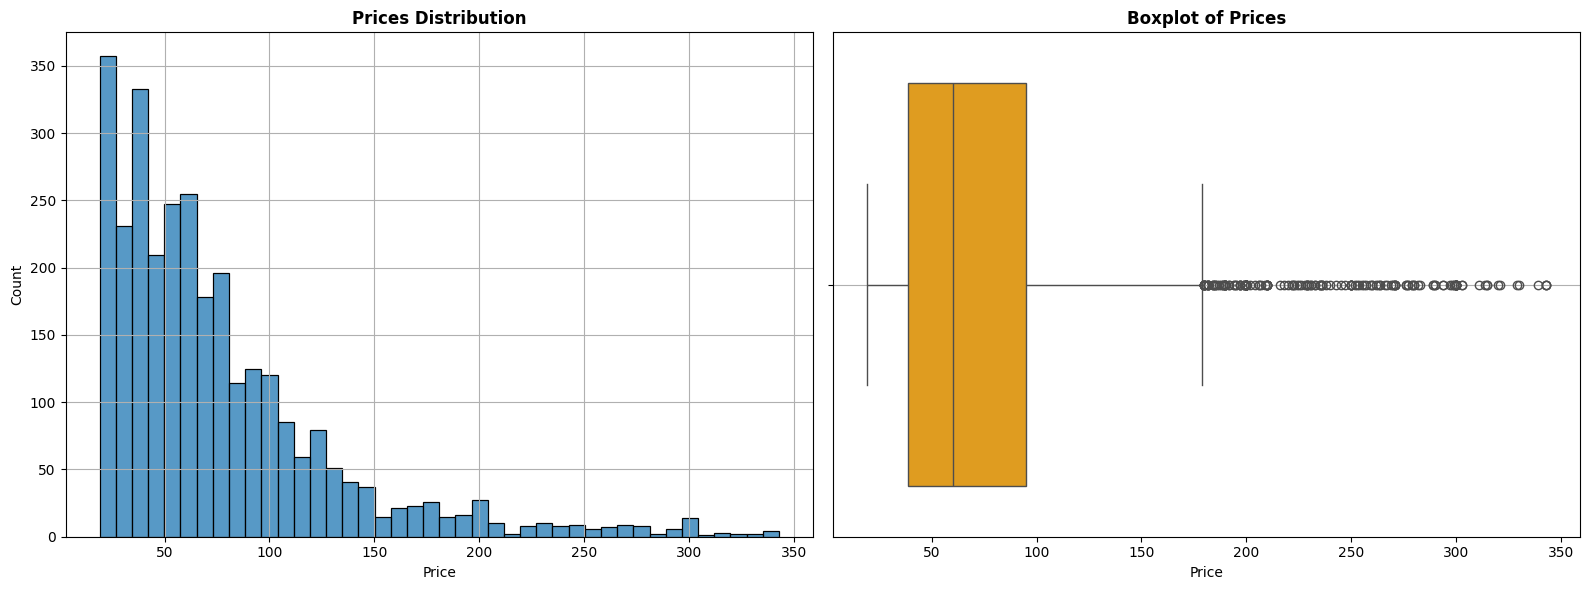

In [11]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.histplot(data['price'])
plt.title('Prices Distribution', weight='bold')
plt.xlabel('Price')
plt.grid()

plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.boxplot(x=data['price'], color='orange')
plt.title('Boxplot of Prices', weight='bold')
plt.xlabel('Price')
plt.grid(axis='y')  # Add gridlines for the boxplot

plt.tight_layout()
plt.show()

* Accommondates

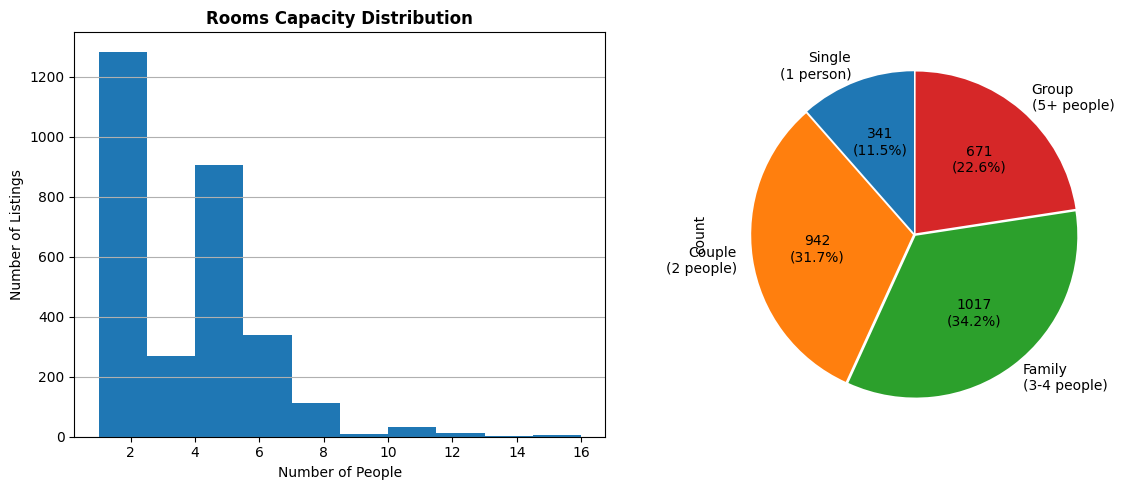

In [12]:
data['accommodates_group'] = (
    data['accommodates']
    .pipe(pd.cut, bins=[1,2,3,5,20], include_lowest=True, right=False, 
          labels=['Single', 'Couple', 'Family', 'Group']))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
data['accommodates'].plot(kind='hist', ax=ax1)

ax1.set_xlabel('Number of People')
ax1.set_ylabel('Number of Listings')
ax1.set_title('Rooms Capacity Distribution', weight='bold')
ax1.grid(axis='y')

pie_data = (data['accommodates_group'].value_counts().sort_index())

pie_data.plot(
    kind='pie', 
    labels=['Single\n(1 person)', 'Couple\n(2 people)', 'Family\n(3-4 people)', 'Group\n(5+ people)'],
    autopct=lambda v: (
         '{}'.format(int(v/100*sum(pie_data))) +
         '\n' + '({:.1%})'.format(v/100)),
    startangle=90,
    explode=(0.01, ) * len(pie_data),
    ax=ax2
    )

fig.tight_layout()
plt.show()

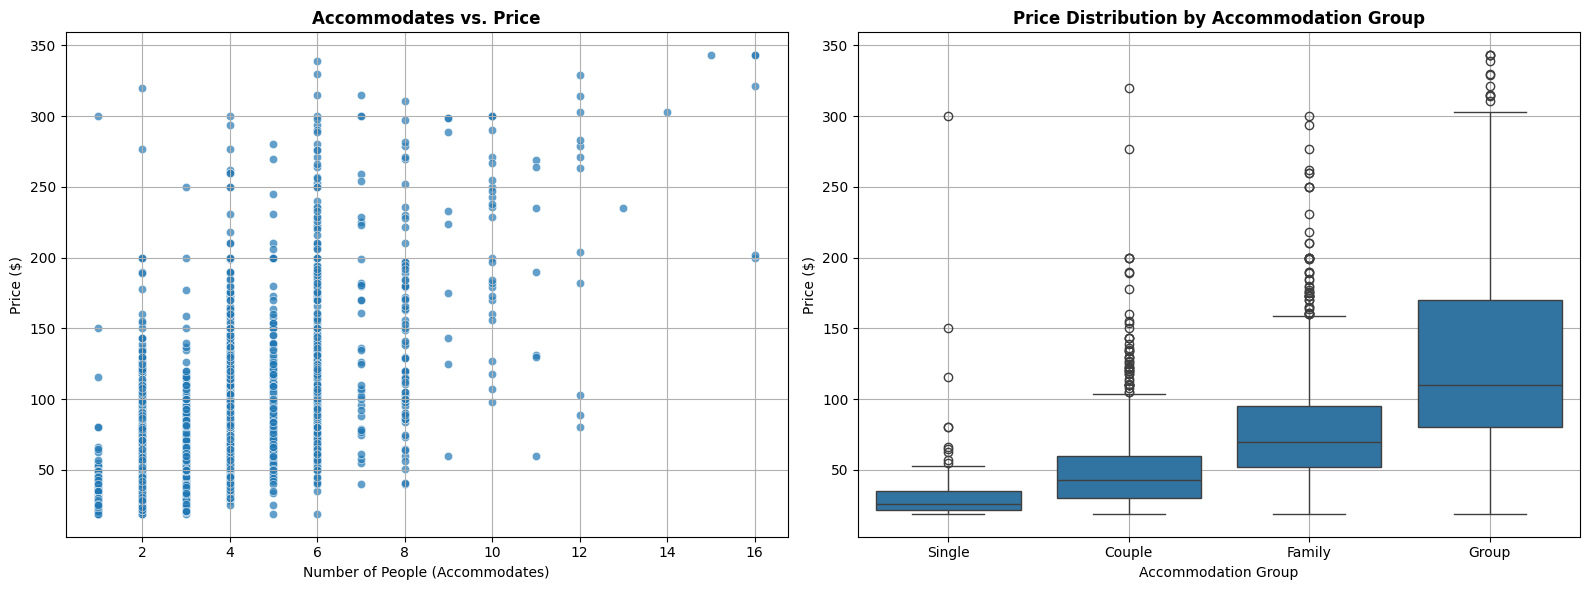

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(data, x='accommodates', y='price', alpha=0.7, ax=ax1)
ax1.set_title('Accommodates vs. Price', weight='bold')
ax1.set_xlabel('Number of People (Accommodates)')
ax1.set_ylabel('Price ($)')
ax1.grid(True)

sns.boxplot(data, x='accommodates_group', y='price', ax=ax2)
ax2.set_title('Price Distribution by Accommodation Group', weight='bold')
ax2.set_xlabel('Accommodation Group')
ax2.set_ylabel('Price ($)')
ax2.grid(True)

plt.tight_layout()
plt.show()

- neighbourhood

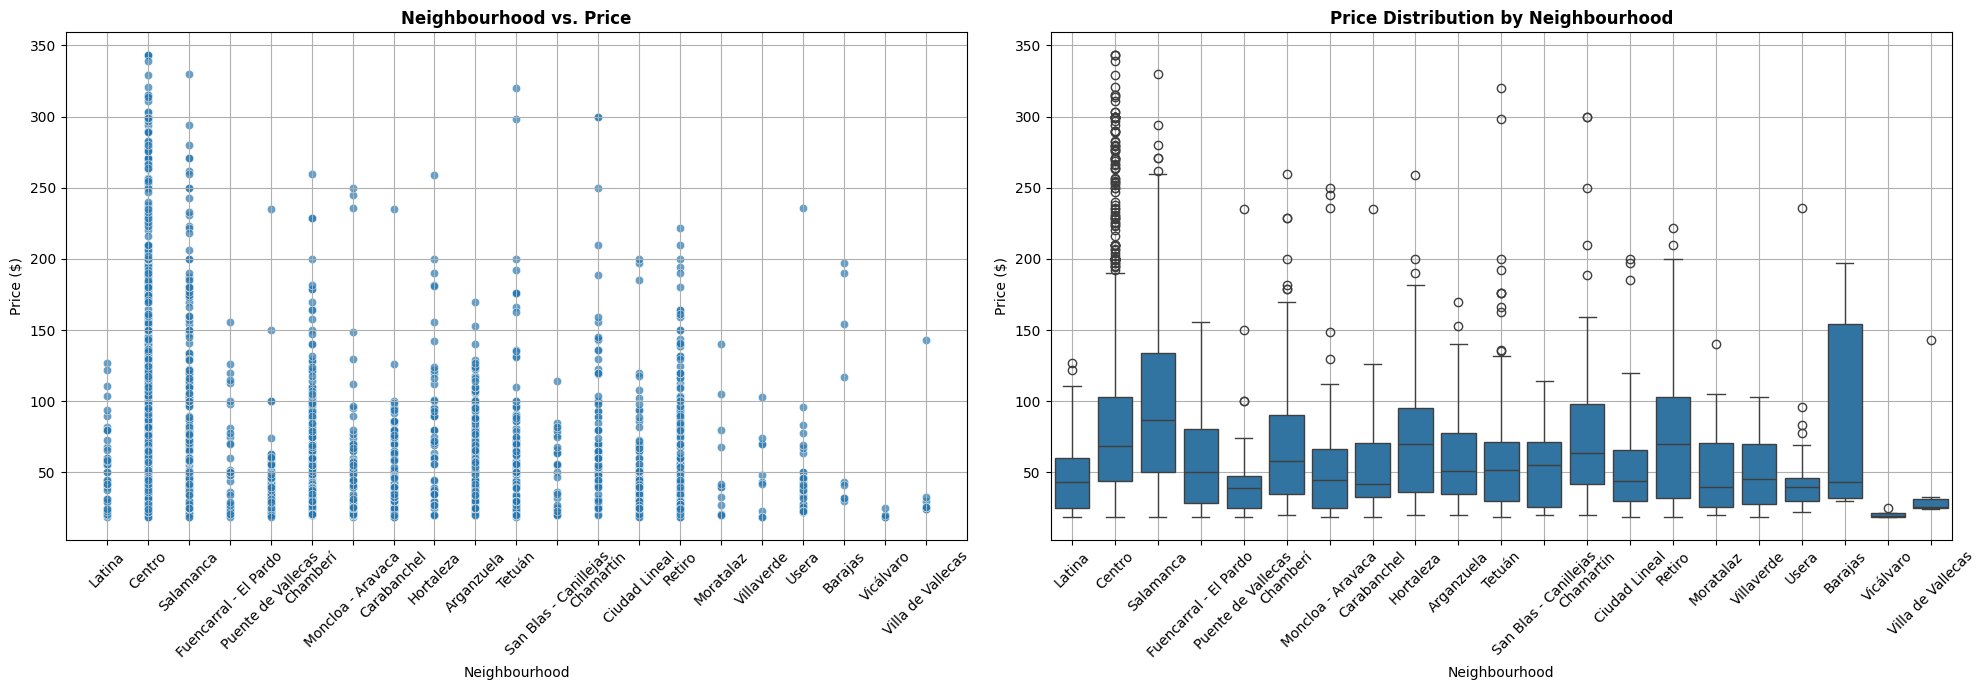

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

sns.scatterplot(data=data, x='neighbourhood_group', y='price', alpha=0.7, ax=ax1)
ax1.set_title('Neighbourhood vs. Price', weight='bold')
ax1.set_xlabel('Neighbourhood')
ax1.set_ylabel('Price ($)')
ax1.grid(True)
ax1.tick_params(axis='x', rotation=45) 

sns.boxplot(data=data, x='neighbourhood_group', y='price', ax=ax2)
ax2.set_title('Price Distribution by Neighbourhood', weight='bold')
ax2.set_xlabel('Neighbourhood')
ax2.set_ylabel('Price ($)')
ax2.grid(True)
ax2.tick_params(axis='x', rotation=45) 

plt.tight_layout()
plt.show()

* Language of the Title 

/var/folders/0p/lv2_5w856k15_4hz_hhnqz8m0000gn/T/ipykernel_11911/3732144658.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x='price', y='language', palette={'en': 'pink', 'es': 'skyblue'})


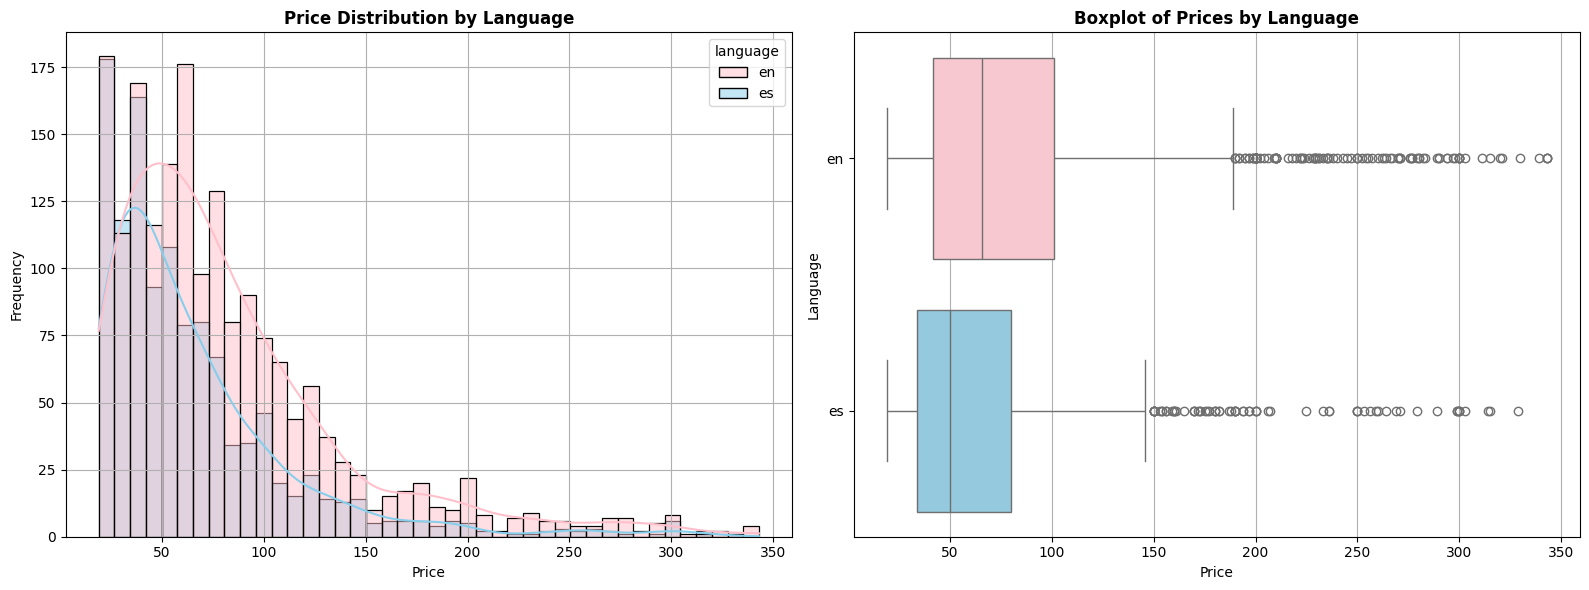

In [15]:
filtered_df = data[data['language'].isin(['es', 'en'])]
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.histplot(data=filtered_df, x='price', hue='language', kde=True, palette={'en': 'pink', 'es': 'skyblue'})
plt.title('Price Distribution by Language', weight='bold')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid()

plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.boxplot(data=filtered_df, x='price', y='language', palette={'en': 'pink', 'es': 'skyblue'})
plt.title('Boxplot of Prices by Language', weight='bold')
plt.xlabel('Price')
plt.ylabel('Language')
plt.grid(axis='x')  # Add gridlines for the boxplot

plt.tight_layout()
plt.show()

* Number and types of bathroom

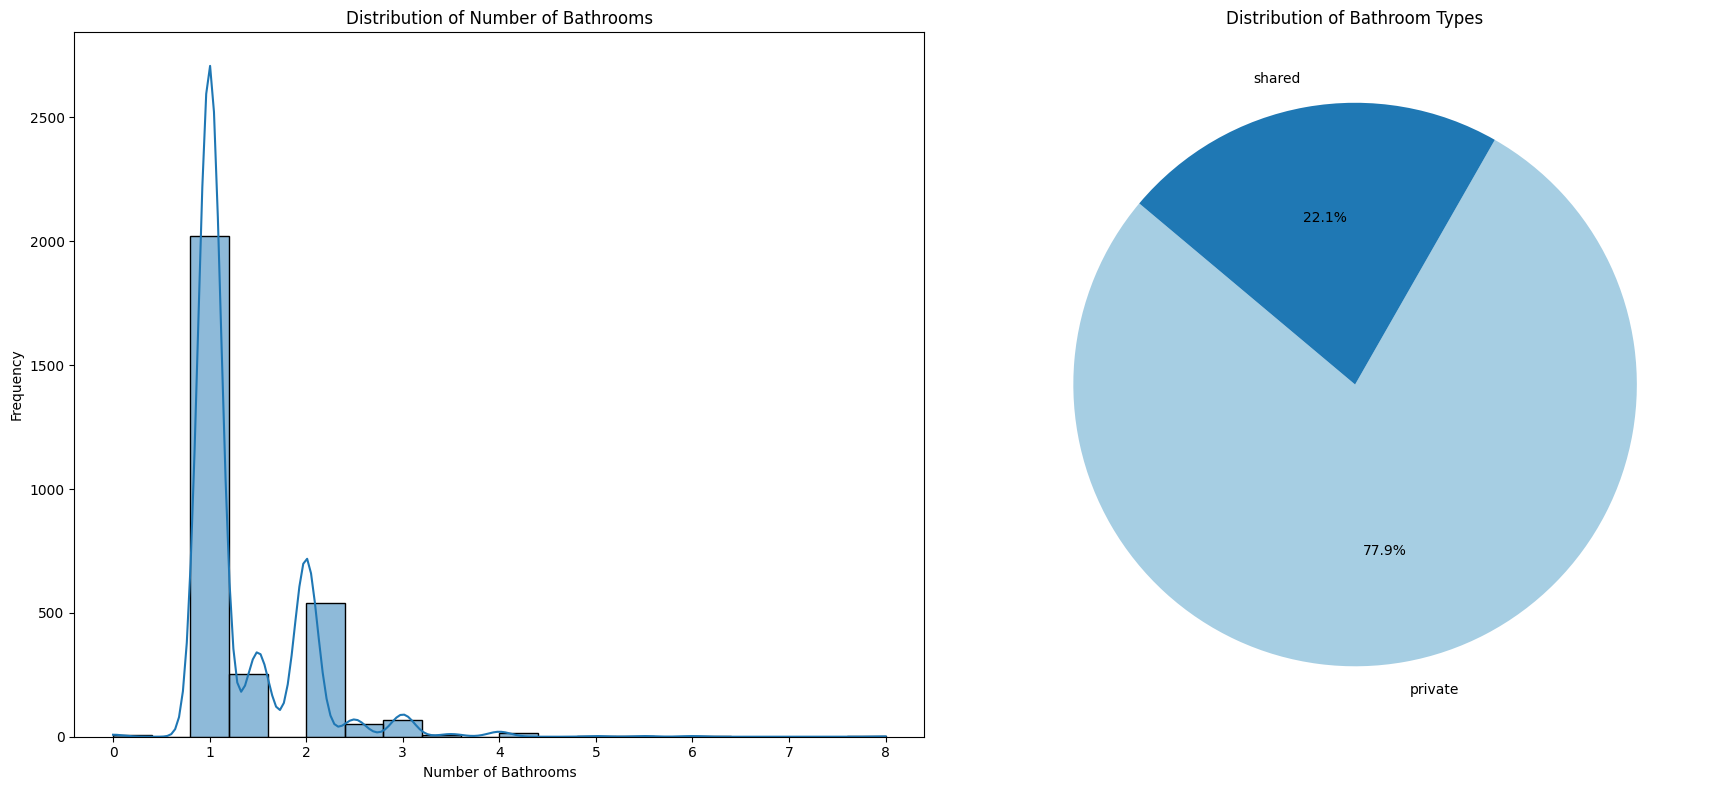

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.histplot(data['bathrooms_number'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Number of Bathrooms')
axes[0].set_xlabel('Number of Bathrooms')
axes[0].set_ylabel('Frequency')

bathrooms_type_counts = data['bathrooms_type'].value_counts()
axes[1].pie(bathrooms_type_counts, labels=bathrooms_type_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
axes[1].set_title('Distribution of Bathroom Types')

plt.tight_layout()
plt.show()

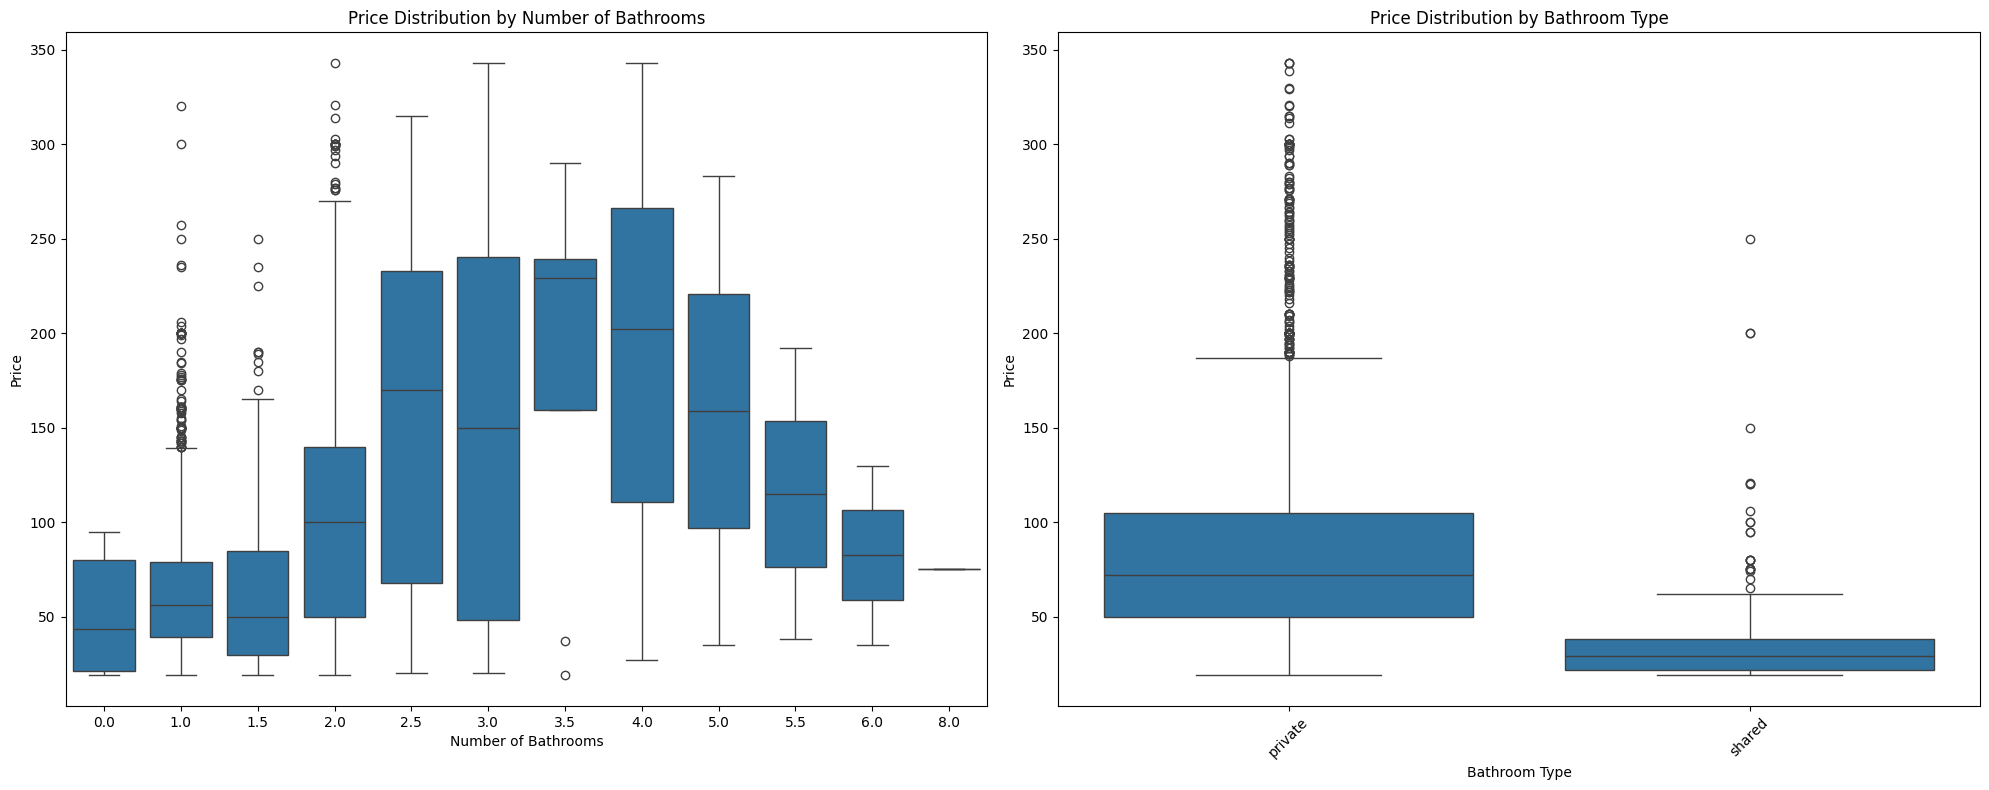

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.boxplot(x='bathrooms_number', y='price', data=data, ax=axes[0])
axes[0].set_title('Price Distribution by Number of Bathrooms')
axes[0].set_xlabel('Number of Bathrooms')
axes[0].set_ylabel('Price')

sns.boxplot(x='bathrooms_type', y='price', data=data, ax=axes[1])
axes[1].set_title('Price Distribution by Bathroom Type')
axes[1].set_xlabel('Bathroom Type')
axes[1].set_ylabel('Price')
axes[1].tick_params(axis='x', rotation=45)  

plt.tight_layout()
plt.show()

Try to find keywords that indicate the price of the listing

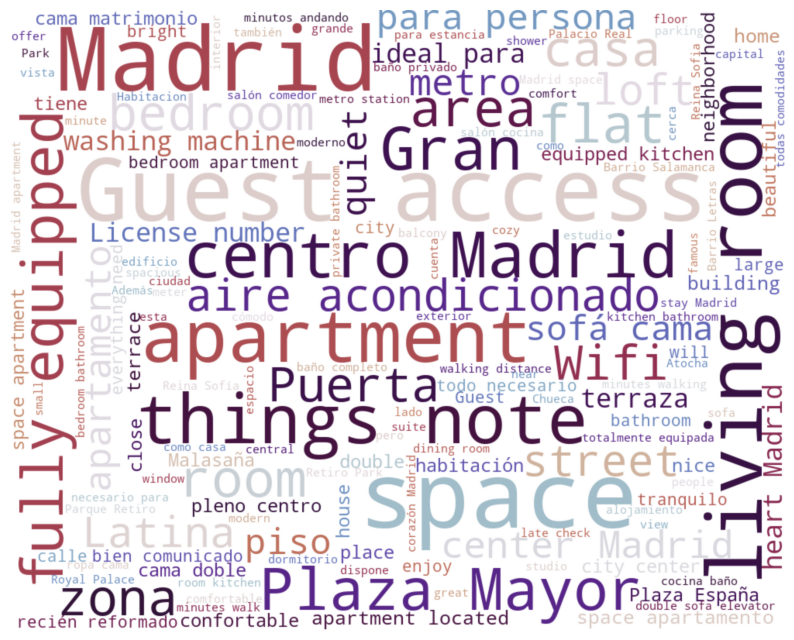

In [18]:
# common used ones
word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = 'twilight_shifted', 
                       margin = 0,
                       max_words = 200,  
                       min_word_length = 4,
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(data['text']))

plt.figure(figsize = (10, 15))
plt.imshow(word_cloud, interpolation = "gaussian")
plt.axis("off")
plt.show()

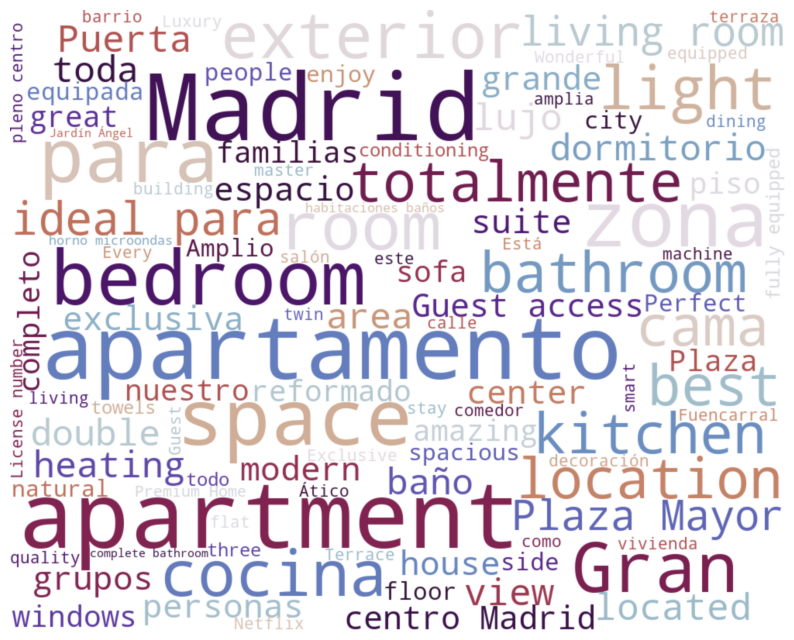

In [19]:
# common used from expensive ones
expensive = data.sort_values(by = 'price', ascending = False)
expensive = expensive.head(20)


word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = 'twilight_shifted', 
                       margin = 0,
                       max_words = 200,  
                       min_word_length = 4,
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(expensive['text']))

plt.figure(figsize = (10, 15))
plt.imshow(word_cloud, interpolation = "gaussian")
plt.axis("off")
plt.show()


possible price related keywords according to the word clouds:

In [20]:
keywords = {
    'modern': ['modern', 'moderno', 'moderna', 'contemporary', 'netflix', 'nuevo', 'último', 'vanguardista'],
    'parking': ['parking', 'aparcamiento', 'garaje', 'estacionamiento'],
    'guest_access': ['guest access', 'acceso de invitados'],
    'fully_equipped': ['fully equipped', 'totalmente equipada', 'equipada', 'equipado', 'completamente equipada', 'con todo lo necesario'],
    'living_room': ['living room', 'salón', 'salon', 'sala de estar', 'salita'],
    'air_conditioning': ['air conditioning', 'aire acondicionado', 'heating', 'calefacción', 'calefaccion', 'conditioning' 'aire', 'clima'],
    'washing_machine': ['washing machine', 'lavadora', 'machine', 'lavadora automática', 'washer'],
    'everything_needed': ['everything needed', 'todo necesario', 'todo lo necesario', 'completo', 'everything'],
    'famous_places': [
        'plaza mayor', 'prado', 'gran vía', 'gran via', 'sol', 'retiro', 'cibeles', 
        'santiago bernabéu', 'santiago bernabeu', 'puerta del sol', 'palacio real', 'alcalá', 'alcala'
        'plaza de españa', 'plaza de espaba','almudena cathedral', 'templo de debod', 
        'reina', 'museo thyssen', 'plaza de cibeles'],
    'terrace': ['terrace', 'terraza', 'balcony', 'balcón', 'exterior', 'balcon', 'patio', 'azotea'],
    'walking_distance': ['walking distance', 'minutos andando', 'a pie', 'cerca caminando', 'cercano'],
    'metro_station': ['metro station', 'estación de metro', 'estacion', 'connected', 'comunicado', 'comunicada', 'bien comunicado', 'bein comunicada', 'metro', 'train', 'tren', 'parada de metro', 'autobus', 'bus'],
    'luxury': ['luxury', 'lujo', 'exclusive', 'exclusivo', 'exclusiva', 'premium', 'quality', 'elegante', 'alto standing'],
    'kitchen': ['kitchen', 'cocina', 'comedor', 'dining room', 'horno', 'oven', 'microondas', 'utensilios', 'nevera', 'frigorífico'],
    'renovated': ['renovated', 'reformado', 'reformada', 'renovada', 'actualizado', 'modernizado'],
    'wifi': ['wifi', 'wlan', 'internet', 'conexión a internet'],
    'compliments': ['charming', 'beautiful', 'hermoso', 'bright', 'cozy', 'bonito', 'love', 'view', 'vista', 'wonderful', 'amazing', 'acogedor', 'precioso', 'encantador', 'increíble'],
    'quite': ['quite', 'tranquilo', 'tranquila', 'silencioso', 'apacible', 'relajante'],
    'size': ['size', 'amplio', 'amplia', 'espacio', 'grande', 'spacious', 'space', 'grandeza', 'extenso']
}

import unicodedata

for keyword, words in keywords.items():
    # Create a regex pattern to check if any of the words are in the text (case insensitive)
    pattern = '|'.join([f'{word}' for word in words])  # '\w*' allows for word variations 
    # Normalize the words to remove accents from the letters and add them to the pattern
    #pattern = '|'.join([f'{unicodedata.normalize("NFD", word).encode("ascii", "ignore").decode()}' for word in words]) 

    data[keyword] = data['text'].str.contains(pattern, case=False)

data = data.drop(['text'], axis=1)
#data.head()

As our data is mostly skewed, use power transformer.

In [21]:
#numeric_cols = list(data._get_numeric_data().columns)
#pt = PowerTransformer(method="yeo-johnson")
#preprocessed_data = data.drop(['name'], axis=1)
#preprocessed_data[numeric_cols] = pt.fit_transform(preprocessed_data[numeric_cols])

# Extract numeric columns for features
feature_cols = [col for col in data._get_numeric_data().columns if col != "price"]
target_col = "price"

# Initialize PowerTransformers for features and target
pt_features = PowerTransformer(method="yeo-johnson")
pt_target = PowerTransformer(method="yeo-johnson")

# Apply transformation separately
preprocessed_data = data.drop(['name'], axis=1)
preprocessed_data[feature_cols] = pt_features.fit_transform(preprocessed_data[feature_cols])
preprocessed_data[target_col] = pt_target.fit_transform(preprocessed_data[[target_col]])


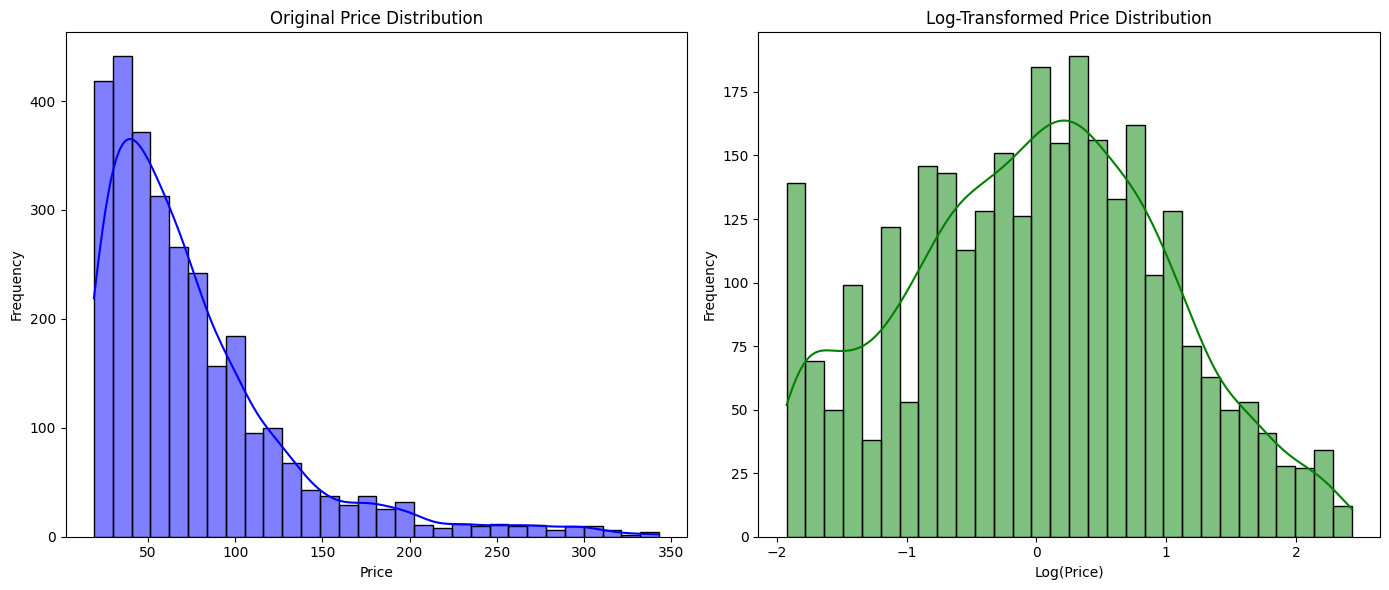

In [22]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.histplot(data['price'], kde=True, color="blue", bins=30)
plt.title("Original Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")

# Plot the log-transformed price distribution
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.histplot(preprocessed_data['price'], kde=True, color="green", bins=30)
plt.title("Log-Transformed Price Distribution")
plt.xlabel("Log(Price)")
plt.ylabel("Frequency")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

Apply one code encoding.

In [23]:
preprocessed_data = pd.get_dummies(preprocessed_data,drop_first=True)
preprocessed_data.head()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,bedrooms,...,neighbourhood_Vista Alegre,neighbourhood_Zofío,room_type_Hotel room,room_type_Private room,room_type_Shared room,language_es,bathrooms_type_shared,accommodates_group_Couple,accommodates_group_Family,accommodates_group_Group
1,-2.236284,-7.077672e-15,-2.286232,-1.062710,0.892530,0.510905,-0.503345,-1.140945,1.125927,-0.679158,...,False,False,False,True,False,False,False,False,False,False
9,-0.313003,-4.163336e-16,0.032935,0.441824,0.304538,1.621565,0.329330,1.182782,0.940553,-0.679158,...,False,False,False,False,False,False,False,False,True,False
10,-2.169067,7.216450e-16,-0.367251,0.636321,1.218118,0.833882,-0.594399,-0.417469,1.074400,-0.679158,...,False,False,False,False,False,False,False,False,True,False
11,-2.082942,2.997602e-15,0.933109,0.497809,1.754758,0.952102,-0.459519,-1.140945,0.993696,1.340248,...,False,False,False,False,False,False,False,False,True,False
14,-2.015616,2.681189e-14,-1.259236,-1.743987,-0.935265,0.561364,-0.416770,-1.140945,1.125927,-0.679158,...,False,False,False,True,False,True,True,True,False,False


Prepare features and targets. Split data into training and test data.

In [24]:
#X = preprocessed_data.drop(["price"], axis = 1)
#y = preprocessed_data["price"]

X = preprocessed_data.drop([target_col], axis=1)
y = preprocessed_data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building regression models
 
We use grid search cross validation to optimize the hyperparameters and avoid overfitting. 

* Random Forest Regressor

In [25]:
"""
param_grid = {
    'n_estimators': [400, 500],
    'max_depth': [20, 21, 22, 24, 25],
    'min_samples_split': [2, 3, 4, 5, 6]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("Best Random Forest Params:", grid_search.best_params_)
print("Train Score R^2: {}".format(best_rf.score(X_train, y_train)))
print("Test Score R^2: {}".format(best_rf.score(X_test, y_test)))
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print("Test RMSE: {}".format(rmse_rf))
print("Test MAE: {}".format(mae_rf))

Best Random Forest Params: {'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 400}
"""

rf = RandomForestRegressor(n_estimators=400, max_depth=25, min_samples_split=2, random_state=42)
rf.fit(X_train, y_train) 
y_pred = rf.predict(X_test)

y_pred_original = pt_target.inverse_transform(y_pred.reshape(-1, 1)).ravel()
y_test_original = pt_target.inverse_transform(y_test.values.reshape(-1, 1)).ravel()

rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)

print("Trainscore R^2: {}".format(rf.score(X_train, y_train))) 
print("Testscore R^2: {}".format(rf.score(X_test, y_test))) 
print("Testdata Root Mean Squared Error: {}".format(rmse))
print("Testdata Mean Absolute Error: {}".format(mae))

Trainscore R^2: 0.9628482087854571
Testscore R^2: 0.7222519400477299
Testdata Root Mean Squared Error: 32.65038112487717
Testdata Mean Absolute Error: 20.08926560137848


/Users/yaren/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/Users/yaren/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


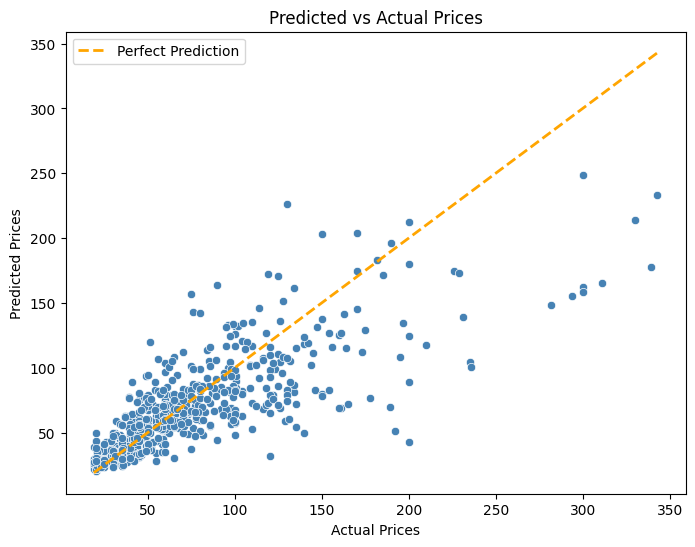

In [26]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_original, y=y_pred_original, color='steelblue')

# Perfect prediction line
plt.plot([min(y_test_original), max(y_test_original)], 
         [min(y_test_original), max(y_test_original)], 
         color='orange', linestyle='--', linewidth=2, label="Perfect Prediction")

# Labels and title
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted vs Actual Prices")
plt.legend()
plt.show()

* Neural Net – MLP

In [27]:
"""
mlp = MLPRegressor(max_iter=1000, random_state=42)
param_grid = {
    'hidden_layer_sizes': [(100,), (100, 50), (20,10),(100,80)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'alpha': [0.0001, 0.001, 0.01],  # Regularization strength,
    'max_iter': [400, 450, 500, 550]
}

grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_mlp = grid_search.best_estimator_

y_pred = best_mlp.predict(X_test)
print("Best Hyperparameters:", grid_search.best_params_)
print("Neural Network Performance After Optimization:")
print("Train Score R^2: ", best_mlp.score(X_train, y_train))
print("Test Score R^2: ", best_mlp.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print("Test RMSE: ", rmse)
print("Test MAE: ", mae)

"""

#Best Hyperparameters: {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 400, 'solver': 'adam'}
mlp = MLPRegressor(activation='logistic',
                   alpha=0.01,
                   hidden_layer_sizes=(100, ),
                   learning_rate='constant',
                   solver='adam',
                   random_state=42,
                   max_iter=400)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

print("Neural Network Model Performance:")
print("Train Score R^2: {}".format(mlp.score(X_train, y_train)))
print("Test Score R^2: {}".format(mlp.score(X_test, y_test)))

y_pred_original_mlp = pt_target.inverse_transform(y_pred_mlp.reshape(-1, 1)).ravel()
y_test_original_mlp = pt_target.inverse_transform(y_test.values.reshape(-1, 1)).ravel()

rmse_mlp = np.sqrt(mean_squared_error(y_test_original_mlp, y_pred_original_mlp))
mae_mlp = mean_absolute_error(y_test_original_mlp, y_pred_original_mlp)

print("Test RMSE: {}".format(rmse_mlp))
print("Test MAE: {}".format(mae_mlp))


Neural Network Model Performance:
Train Score R^2: 0.8914201564677265
Test Score R^2: 0.698922764362604
Test RMSE: 33.55384592881415
Test MAE: 21.61098795545362


/Users/yaren/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yaren/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/Users/yaren/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


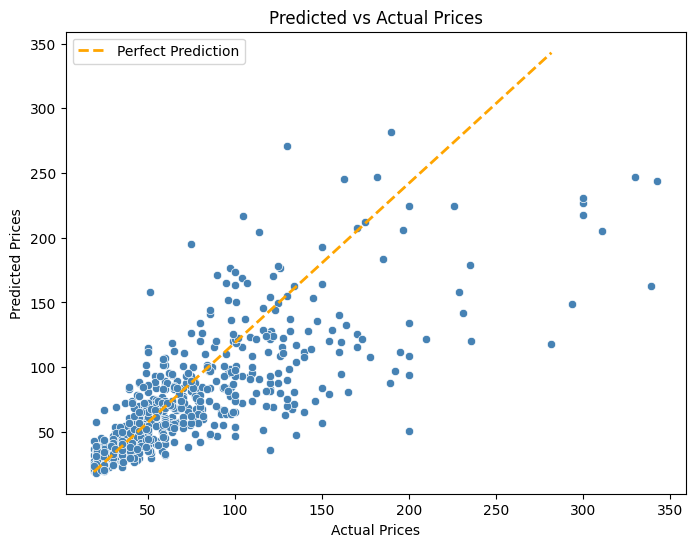

In [28]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_original_mlp, y=y_pred_original_mlp, color='steelblue')

# Perfect prediction line
plt.plot([min(y_test_original_mlp), max(y_pred_original_mlp)], 
         [min(y_test_original_mlp), max(y_test_original_mlp)], 
         color='orange', linestyle='--', linewidth=2, label="Perfect Prediction")

# Labels and title
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted vs Actual Prices")
plt.legend()
plt.show()

* XGB

In [29]:
"""
gbr = GradientBoostingRegressor(random_state=42)
param_grid = {
    'n_estimators': [750, 800, 850],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [7, 7, 8],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_gbr = grid_search.best_estimator_
y_pred = best_gbr.predict(X_test)

print("Best Hyperparameters:", grid_search.best_params_)
print("Gradient Boosting Performance After Optimization:")
print("Train Score R^2: ", best_gbr.score(X_train, y_train))
print("Test Score R^2: ", best_gbr.score(X_test, y_test))

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print("Test RMSE: ", rmse)
print("Test MAE: ", mae)

"""
#Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 800, 'subsample': 1.0}

gbr = GradientBoostingRegressor( learning_rate=0.05,
                                max_depth=7,
                                max_features='sqrt',
                                min_samples_leaf=2,
                                min_samples_split=10,
                                n_estimators=800,
                                subsample=1.0, 
                                random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

print("Gradient Boosting Model Performance:")
print("Train Score R^2: {}".format(gbr.score(X_train, y_train)))
print("Test Score R^2: {}".format(gbr.score(X_test, y_test)))

y_pred_original_gbr = pt_target.inverse_transform(y_pred_gbr.reshape(-1, 1)).ravel()
y_test_original_gbr = pt_target.inverse_transform(y_test.values.reshape(-1, 1)).ravel()

rmse_gbr = np.sqrt(mean_squared_error(y_test_original_gbr, y_pred_original_gbr))
mae_gbr = mean_absolute_error(y_test_original_gbr, y_pred_original_gbr)
print("Test RMSE: {}".format(rmse_gbr))
print("Test MAE: {}".format(mae_gbr))


Gradient Boosting Model Performance:
Train Score R^2: 0.9878312486443246
Test Score R^2: 0.7623905956992263
Test RMSE: 29.851655696635014
Test MAE: 18.306588106087275


/Users/yaren/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/Users/yaren/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


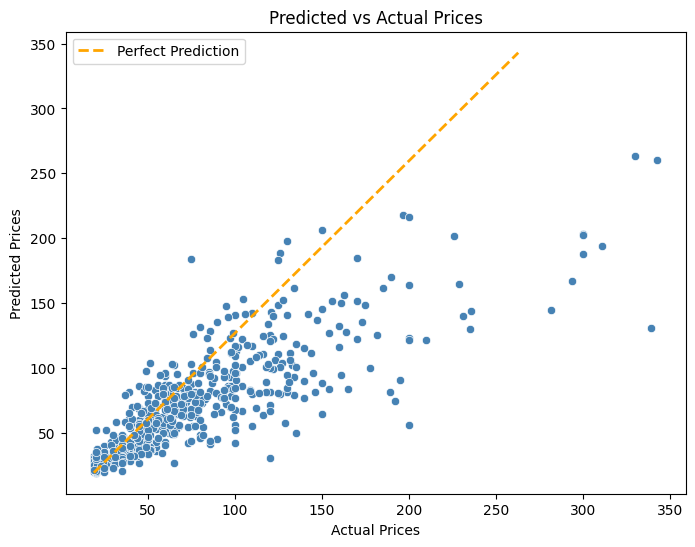

In [30]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_original_gbr, y=y_pred_original_gbr, color='steelblue')

# Perfect prediction line
plt.plot([min(y_test_original_gbr), max(y_pred_original_gbr)], 
         [min(y_test_original_gbr), max(y_test_original_gbr)], 
         color='orange', linestyle='--', linewidth=2, label="Perfect Prediction")

# Labels and title
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted vs Actual Prices")
plt.legend()
plt.show()

# Feature importances

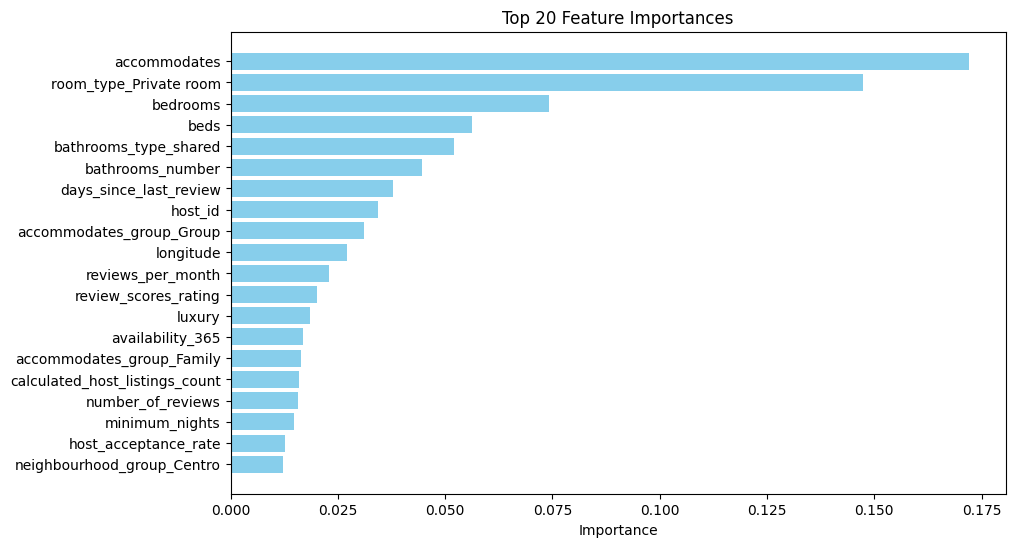

In [31]:
importances = gbr.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
#print(feature_importance_df)
top_n = 20
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Higher importance at the top
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances')
plt.show()

# Analysis of Seasonality
Presenting as an idea of improvement of the model further. 

In [32]:
c = calendar
c['date'] = pd.to_datetime(c['date'])
c['price'] = c['price'].replace('[\$,]', '', regex=True).astype(float)
c['adjusted_price'] = c['adjusted_price'].replace('[\$,]', '', regex=True).astype(float)

q1 = c['price'].quantile(0.25)
q3 = c['price'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
c = c[(c['price'] >= lower_bound) & (c['price'] <= upper_bound)]

# Add month and year columns
c['month'] = c['date'].dt.month
c['year'] = c['date'].dt.year
c['year_month'] = c['date'].dt.to_period('M')


/var/folders/0p/lv2_5w856k15_4hz_hhnqz8m0000gn/T/ipykernel_11911/150403669.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['month'] = c['date'].dt.month
/var/folders/0p/lv2_5w856k15_4hz_hhnqz8m0000gn/T/ipykernel_11911/150403669.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['year'] = c['date'].dt.year
/var/folders/0p/lv2_5w856k15_4hz_hhnqz8m0000gn/T/ipykernel_11911/150403669.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

listing_id
6369        60.000000
21853       31.438356
23001       50.000000
24805       92.134247
26825       25.569863
              ...    
49185822    22.745205
49186179    20.580822
49187258    22.460274
49187471    18.665753
49187791    19.665753
Name: price, Length: 18273, dtype: float64


/var/folders/0p/lv2_5w856k15_4hz_hhnqz8m0000gn/T/ipykernel_11911/3233186845.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_listing.sort_values('date', inplace=True)


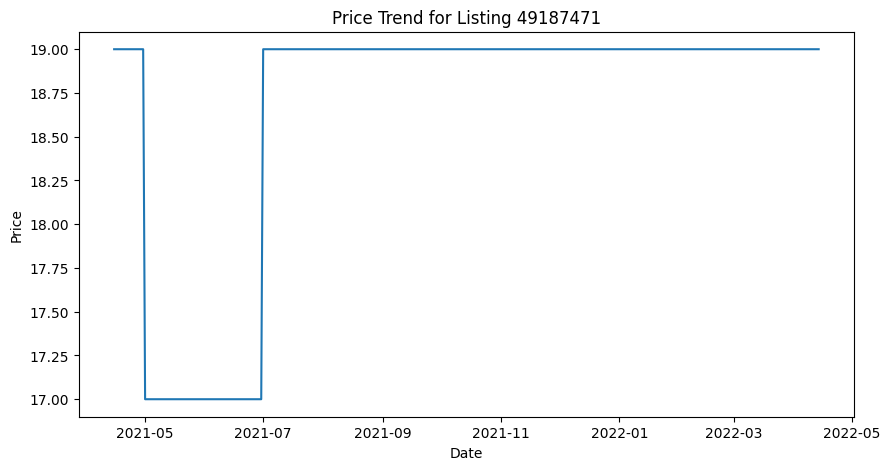

In [33]:
# Average price per listing
listing_avg_price = c.groupby('listing_id')['price'].mean()
print(listing_avg_price)

# Analyze trends over time for a specific listing
listing_id = 49187471  # Replace with an actual listing_id
specific_listing = c[c['listing_id'] == listing_id]
specific_listing.sort_values('date', inplace=True)


plt.figure(figsize=(10, 5))
plt.plot(specific_listing['date'], specific_listing['price'])
plt.title(f'Price Trend for Listing {listing_id}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


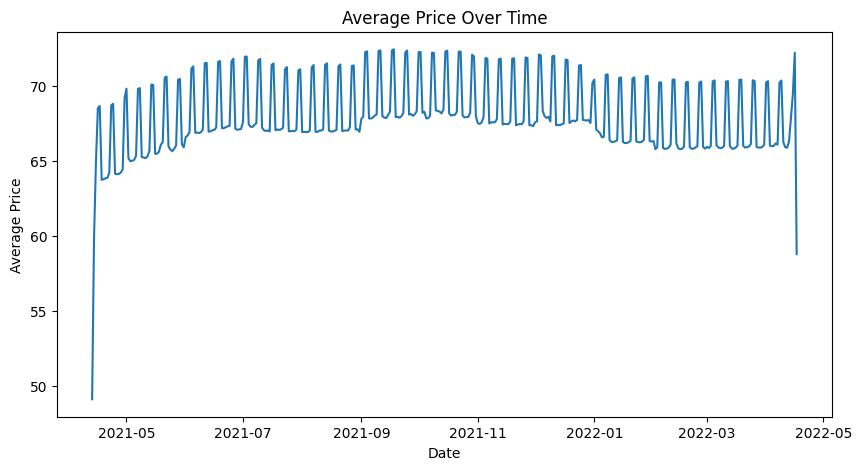

In [34]:
# Aggregate by date for all listings
average_daily_price = c.groupby('date')['price'].mean()

# Plot the overall trend
plt.figure(figsize=(10, 5))
plt.plot(average_daily_price.index, average_daily_price.values)
plt.title('Average Price Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.show()

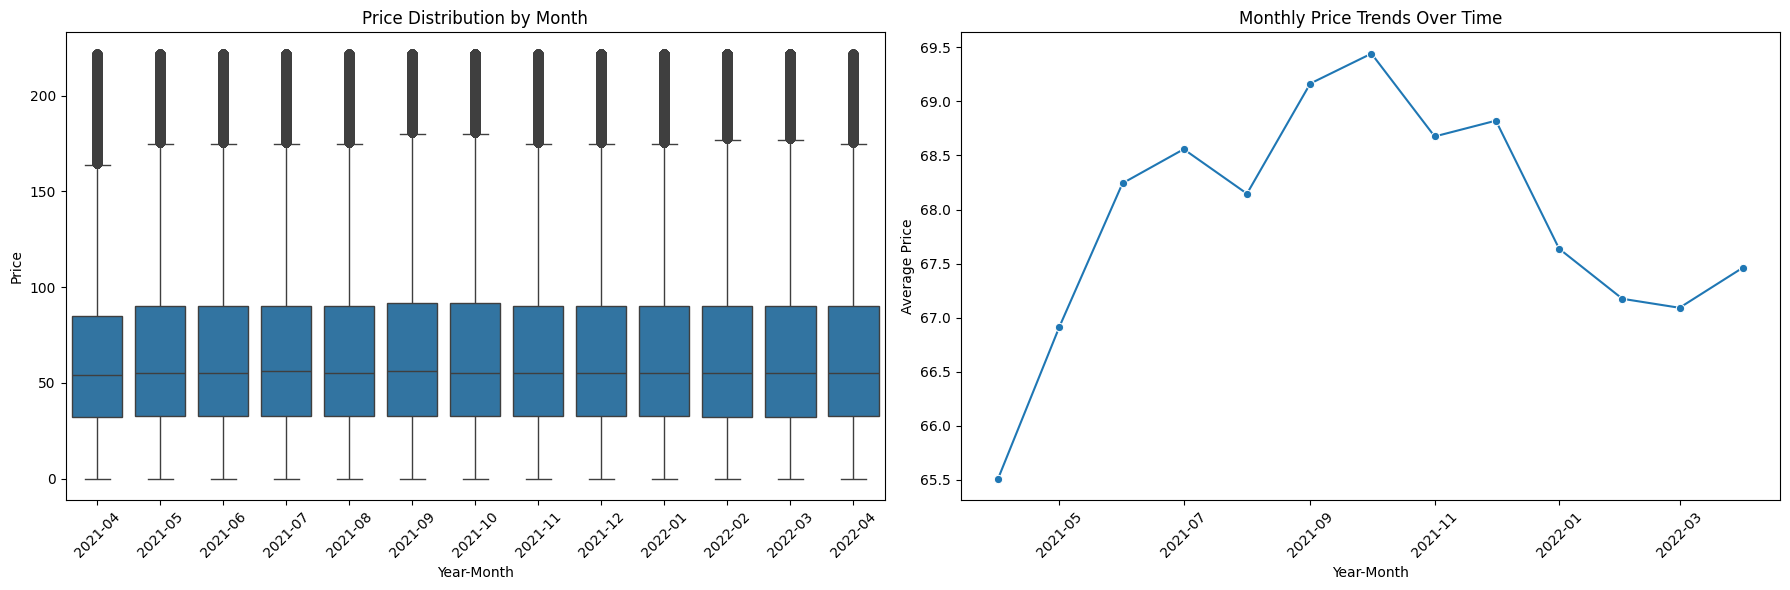

In [35]:
monthly_avg_price = c.groupby('year_month')['price'].mean().reset_index()
monthly_avg_price['year_month'] = monthly_avg_price['year_month'].dt.to_timestamp()
monthly_avg_price.sort_values(by='year_month', inplace=True)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  

# ---- Subplot 1: Boxplot of Prices by Year-Month ----
sns.boxplot(
    data=c,
    x=c['date'].dt.to_period('M').astype(str), 
    y='price',
    ax=axes[0]  
)
axes[0].set_title('Price Distribution by Month')
axes[0].set_xlabel('Year-Month')
axes[0].set_ylabel('Price')
axes[0].tick_params(axis='x', rotation=45)  

# ---- Subplot 2: Line Plot of Average Monthly Prices ----
sns.lineplot(
    data=monthly_avg_price,
    x='year_month',
    y='price',
    marker='o',
    ax=axes[1] 
)
axes[1].set_title('Monthly Price Trends Over Time')
axes[1].set_xlabel('Year-Month')
axes[1].set_ylabel('Average Price')
axes[1].tick_params(axis='x', rotation=45)  

plt.tight_layout()
plt.show()
